<a href="https://colab.research.google.com/github/Artsplendr/Chest-XRays-JPEG-Pneumonia-Classification/blob/main/Inception_ResNet_V2_Chest_Xray_(JPEG)_Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References ##

*  Dataset "Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification" by Daniel Kermany,
Kang Zhang, Michael Goldbaum, is available [at this link](https://data.mendeley.com/datasets/rscbjbr9sj/2);
*  "Pediatric Pneumonia Chest X-ray" dataset is available at [this ](https://www.kaggle.com/andrewmvd/pediatric-pneumonia-chest-xray)link;

*  "Pneuminia Detection" by V. Sivashankari, available [at this link](https://github.com/sivashankari-pro/pneumonia-detection-);
*  "Beating everything with Depthwise Convolution" implementation by NAIN is available [at this link](https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution/data);
* "Image Classification" example by tensorflow.org is available [at the link](https://www.tensorflow.org/tutorials/images/classification);

* "[Review]Transfusion: Understanding Transfer Learning for Medical Imaging" by Tobiloba Adejumo [at the following link](https://medium.com/ai-black-box/transfusion-understanding-transfer-learning-for-medical-imaging-13b06d65aca1);

* Tutorial "Retraining an Image Classifier" by Tensorflow.org at the following [link](https://www.tensorflow.org/hub/tutorials/tf2_image_retraining);

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Project Folder:
%cd /content/drive/MyDrive/Chest_Xray_JPEG_Pneumonia_Detection

/content/drive/MyDrive/Chest_Xray_JPEG_Pneumonia_Detection


## Set-up ##

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.4.0
Hub version: 0.11.0
GPU is available


In [ ]:
# Clear Memory
from keras import backend as K
K.clear_session()

## Select the TF2 SavedModel module to use ##

TF2 models that generate image feature vectors, can be found [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2)

In [ ]:
module_selection = ("imagenet/inception_resnet_v2/feature_vector", 299)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/imagenet/inception_resnet_v2/feature_vector/feature_vector/4 with input size (299, 299)


## Set up the dataset ##

In [ ]:
# Load the data

base_dir = '/content/drive/MyDrive/Chest_Xray_JPEG_Pneumonia_Detection'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
test_new_dir = os.path.join(base_dir, 'test_unseen_pediatric')


In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = datagen.flow_from_directory(
    train_dir, subset="validation", shuffle=False, **dataflow_kwargs)
test_generator = datagen.flow_from_directory(
    test_dir, shuffle=False, **dataflow_kwargs)
test_new_generator = datagen.flow_from_directory(
    test_new_dir, shuffle=False, **dataflow_kwargs)

do_data_augmentation = True

if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = datagen
train_generator = train_datagen.flow_from_directory(
    train_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 17 images belonging to 2 classes.
Found 4187 images belonging to 2 classes.


## Define the model ##

In [ ]:
do_fine_tuning = False

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4", trainable=do_fine_tuning),
    tf.keras.layers.Dense(2048, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(train_generator.num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()


Building model with https://tfhub.dev/google/imagenet/imagenet/inception_resnet_v2/feature_vector/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 2048)              3147776   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_______

In [ ]:
from keras import backend as K

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

METRICS = ['accuracy',
           precision,
           recall]

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint('/SavedModelTF2/Inception_resnet_v2/model.h5', monitor='val_loss', save_best_only=True)

## Training the model ##

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics= METRICS)

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=12, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks = [checkpoint, es]).history

Epoch 1/12
130/130 [==============================] - 3299s 25s/step - loss: 1.0056 - accuracy: 0.7500 - precision: 0.8105 - recall: 0.8484 - val_loss: 0.6555 - val_accuracy: 0.8486 - val_precision: 0.7425 - val_recall: 0.7461
Epoch 2/12
130/130 [==============================] - 222s 2s/step - loss: 0.6000 - accuracy: 0.9044 - precision: 0.9327 - recall: 0.9415 - val_loss: 0.5866 - val_accuracy: 0.9014 - val_precision: 0.7500 - val_recall: 0.6712
Epoch 3/12
130/130 [==============================] - 221s 2s/step - loss: 0.5387 - accuracy: 0.9092 - precision: 0.9378 - recall: 0.9415 - val_loss: 0.6055 - val_accuracy: 0.8398 - val_precision: 0.7500 - val_recall: 0.5957
Epoch 4/12
130/130 [==============================] - 219s 2s/step - loss: 0.4888 - accuracy: 0.9230 - precision: 0.9479 - recall: 0.9517 - val_loss: 0.4822 - val_accuracy: 0.9277 - val_precision: 0.7500 - val_recall: 0.7090
Epoch 5/12
130/130 [==============================] - 223s 2s/step - loss: 0.4519 - accuracy: 0.92

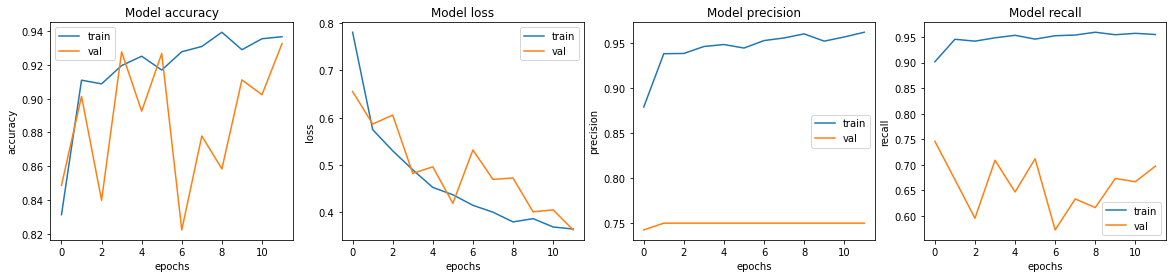

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax[i].plot(hist[met])
    ax[i].plot(hist['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Fine-tune the model ##

In [ ]:
do_fine_tuning = True

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/4", trainable=do_fine_tuning),
    tf.keras.layers.Dense(2048, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(train_generator.num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/imagenet/inception_resnet_v2/feature_vector/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              23853833  
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              2052096   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_____

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=[METRICS])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=12, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    shuffle=True,
    validation_steps=validation_steps).history

Epoch 1/12
130/130 [==============================] - 262s 2s/step - loss: 1.0476 - accuracy: 0.8632 - precision: 0.8903 - recall: 0.9401 - val_loss: 1.0664 - val_accuracy: 0.8730 - val_precision: 0.7500 - val_recall: 0.6237
Epoch 2/12
130/130 [==============================] - 235s 2s/step - loss: 0.9095 - accuracy: 0.9621 - precision: 0.9763 - recall: 0.9741 - val_loss: 1.0358 - val_accuracy: 0.9062 - val_precision: 0.7500 - val_recall: 0.6566
Epoch 3/12
130/130 [==============================] - 232s 2s/step - loss: 0.8957 - accuracy: 0.9647 - precision: 0.9757 - recall: 0.9772 - val_loss: 0.8739 - val_accuracy: 0.9766 - val_precision: 0.7500 - val_recall: 0.7354
Epoch 4/12
130/130 [==============================] - 230s 2s/step - loss: 0.8702 - accuracy: 0.9816 - precision: 0.9886 - recall: 0.9872 - val_loss: 1.1783 - val_accuracy: 0.7959 - val_precision: 0.7500 - val_recall: 0.5452
Epoch 5/12
130/130 [==============================] - 227s 2s/step - loss: 0.8637 - accuracy: 0.9759

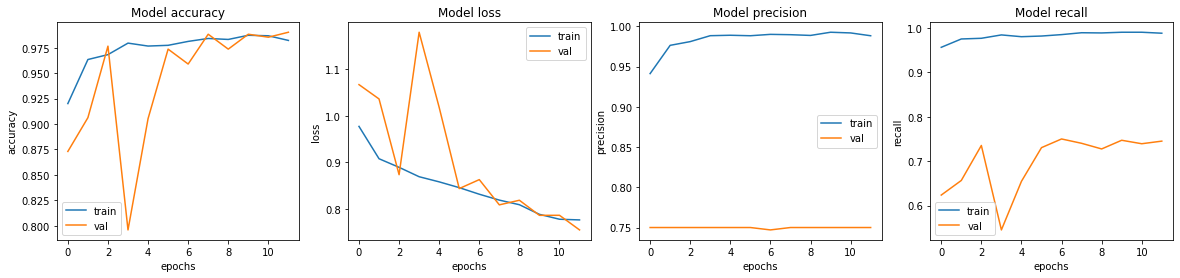

In [ ]:
# plotting fine-tuned model performance:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax[i].plot(hist[met])
    ax[i].plot(hist['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

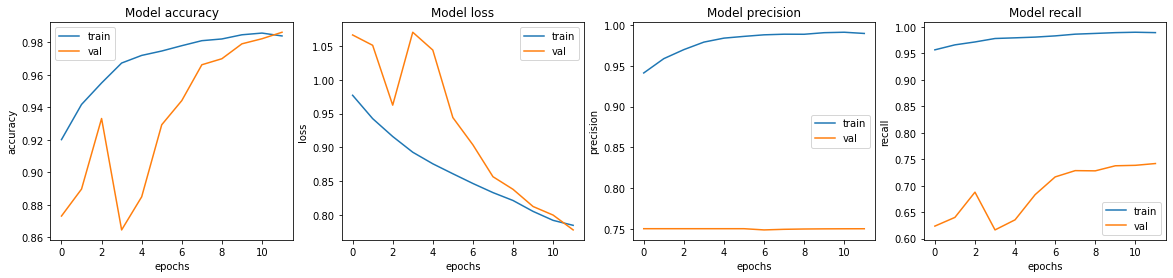

In [ ]:
# Plotting smoothed curves:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax = ax.ravel()

def smooth_curve(points, factor=0.5):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax[i].plot(smooth_curve(hist[metric]))
    ax[i].plot(smooth_curve(hist['val_' + metric]))
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

In [ ]:
model.save('/SavedModelTF2/InceptionV3/InceptionResNetV2_FT')

INFO:tensorflow:Assets written to: /SavedModelTF2/InceptionV3/InceptionResNetV2_FT/assets


INFO:tensorflow:Assets written to: /SavedModelTF2/InceptionV3/InceptionResNetV2_FT/assets


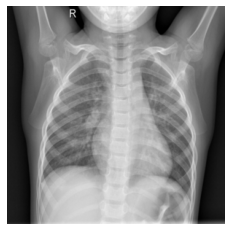

True label: NORMAL
Predicted label: NORMAL


In [ ]:
# Try out the model on an image from the validation data:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

## Evaluate the model ##


In [ ]:
test_loss, test_score, precision, recall = model.evaluate(test_generator, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)
print("Model precision: ", precision)
print("Model recall: ", recall)

20/20 [==============================] - 15s 672ms/step - loss: 1.0227 - accuracy: 0.8478 - precision: 0.6407 - recall: 0.6484
Loss on test set:  1.0227380990982056
Accuracy on test set:  0.8477563858032227
Model precision:  0.6407407522201538
Model recall:  0.6484375


## Model prediction on test data ##

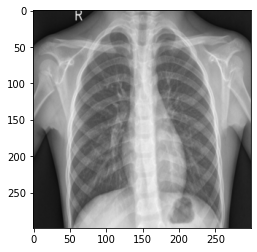

correct class:  NORMAL
predicted class: NORMAL


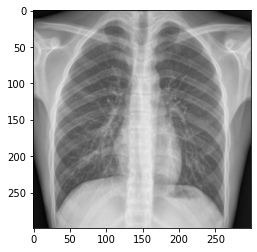

correct class:  NORMAL
predicted class: NORMAL


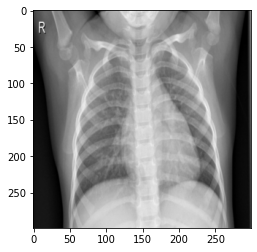

correct class:  NORMAL
predicted class: NORMAL


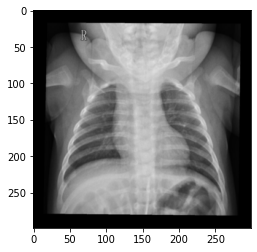

correct class:  NORMAL
predicted class: NORMAL


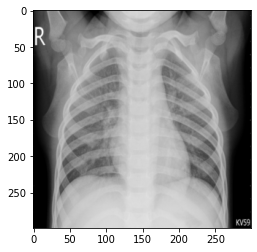

correct class:  NORMAL
predicted class: PNEUMONIA


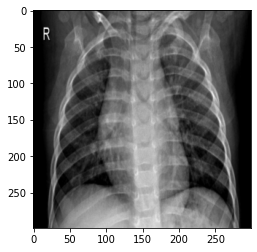

correct class:  NORMAL
predicted class: PNEUMONIA


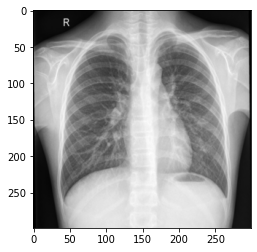

correct class:  NORMAL
predicted class: NORMAL


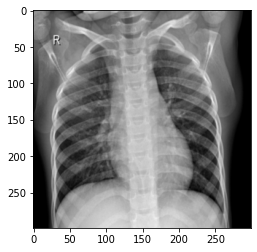

correct class:  NORMAL
predicted class: NORMAL


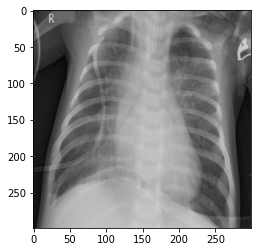

correct class:  PNEUMONIA
predicted class: PNEUMONIA


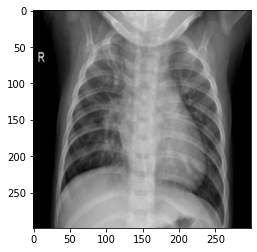

correct class:  PNEUMONIA
predicted class: PNEUMONIA


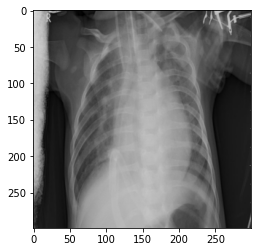

correct class:  PNEUMONIA
predicted class: PNEUMONIA


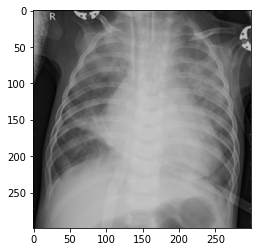

correct class:  PNEUMONIA
predicted class: PNEUMONIA


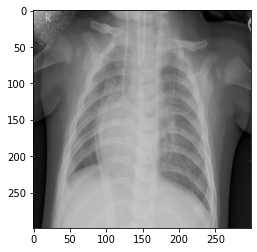

correct class:  PNEUMONIA
predicted class: PNEUMONIA


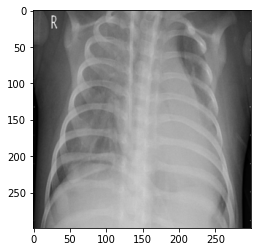

correct class:  PNEUMONIA
predicted class: PNEUMONIA


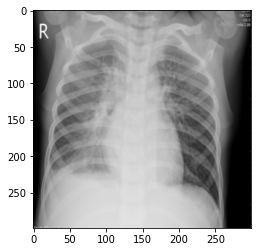

correct class:  PNEUMONIA
predicted class: PNEUMONIA


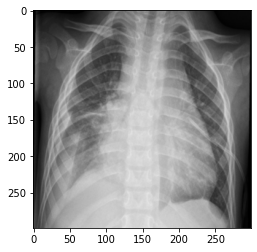

correct class:  PNEUMONIA
predicted class: PNEUMONIA


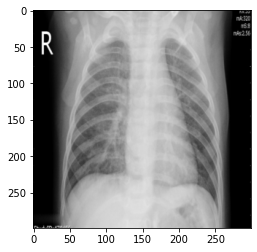

correct class:  PNEUMONIA
predicted class: PNEUMONIA


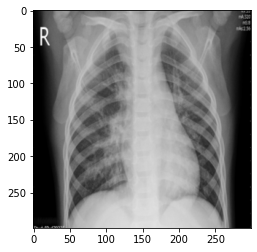

correct class:  PNEUMONIA
predicted class: PNEUMONIA


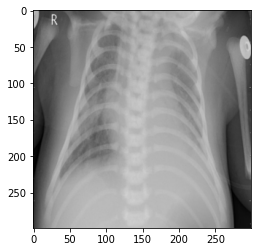

correct class:  PNEUMONIA
predicted class: PNEUMONIA


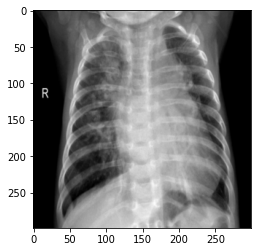

correct class:  PNEUMONIA
predicted class: PNEUMONIA


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
'''
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(pixels, pixels),
batch_size=1)
'''
for n in range(20):
  _ = test_generator.next()
  image, classifier = (_[0][0],_[1][0])
  index = np.argmax(classifier)
  answer = list(test_generator.class_indices.keys())[index]
  predicted = model.predict(np.asarray([image]))
  predicted_answer_index = np.argmax(predicted[0])
  predicted_answer = list(test_generator.class_indices.keys())[predicted_answer_index]
  plt.imshow(image)
  plt.show()
  print('correct class: ', answer)
  print('predicted class:', predicted_answer)

###### Summary: Two out of 20 predictions are not correct (90% accuracy);

## Model prediction on new unseen data (pediatric chest x-rays dataset )##


Let's see how the model predicts on unseen childern chest X-Rays, after being trained on adults chest X-Rays...

Found 17 images belonging to 2 classes.


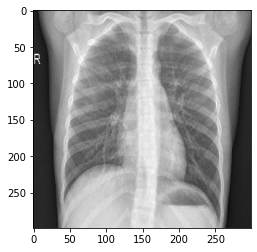

correct class:  NORMAL
predicted class: PNEUMONIA


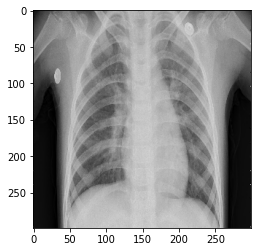

correct class:  PNEUMONIA
predicted class: PNEUMONIA


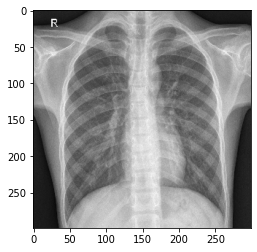

correct class:  NORMAL
predicted class: PNEUMONIA


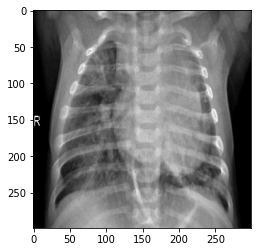

correct class:  PNEUMONIA
predicted class: PNEUMONIA


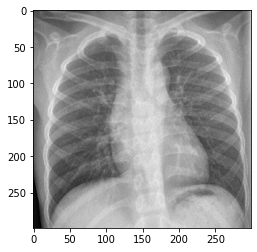

correct class:  NORMAL
predicted class: PNEUMONIA


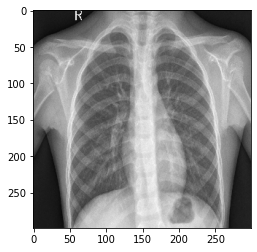

correct class:  NORMAL
predicted class: PNEUMONIA


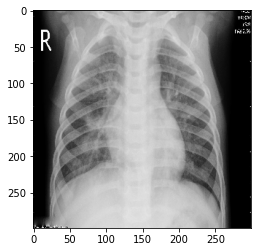

correct class:  PNEUMONIA
predicted class: PNEUMONIA


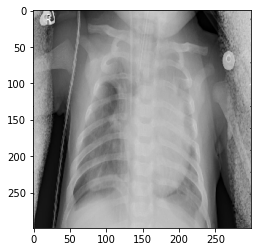

correct class:  PNEUMONIA
predicted class: PNEUMONIA


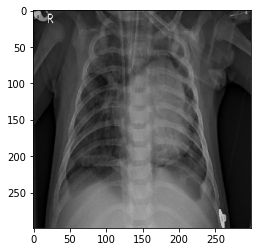

correct class:  PNEUMONIA
predicted class: PNEUMONIA


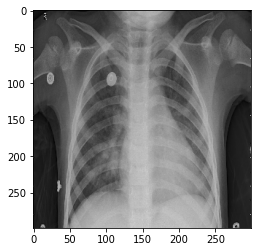

correct class:  PNEUMONIA
predicted class: PNEUMONIA


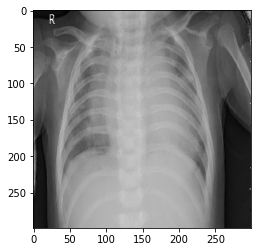

correct class:  PNEUMONIA
predicted class: PNEUMONIA


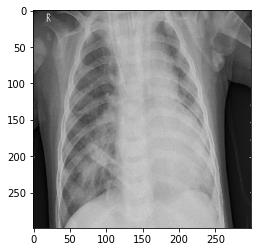

correct class:  PNEUMONIA
predicted class: PNEUMONIA


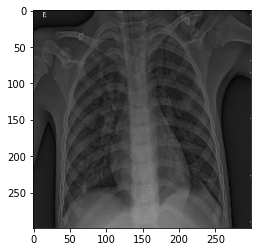

correct class:  PNEUMONIA
predicted class: PNEUMONIA


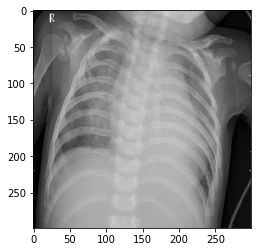

correct class:  PNEUMONIA
predicted class: PNEUMONIA


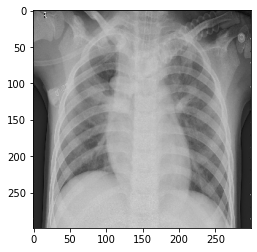

correct class:  PNEUMONIA
predicted class: PNEUMONIA


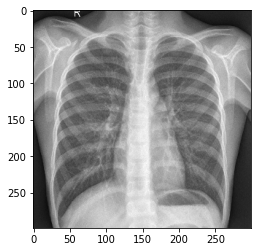

correct class:  NORMAL
predicted class: PNEUMONIA


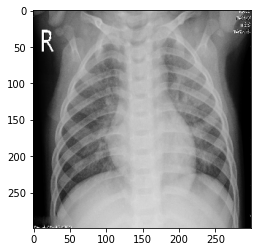

correct class:  PNEUMONIA
predicted class: PNEUMONIA


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
test_new_dir,
target_size=(pixels,pixels),
batch_size=1)

 
for n in range(17):
  _ = test_generator.next()
  image, classifier = (_[0][0],_[1][0])
  index = np.argmax(classifier)
  answer = list(test_generator.class_indices.keys())[index]
  predicted = model.predict(np.asarray([image]))
  predicted_answer_index = np.argmax(predicted[0])
  predicted_answer = list(test_generator.class_indices.keys())[predicted_answer_index]
  plt.imshow(image)
  plt.show()
  print('correct class: ', answer)
  print('predicted class:', predicted_answer)


##### Summary: Five out of 17 predictions are not correct (70% accuracy on unseen chest X-rays of children);